In [1]:
import polars as pl
DATA_DIR = "data"

# load all 2024 months of taxi rides
dfs = []
for month in range(1, 13):
    df = pl.scan_parquet(f"{DATA_DIR}/{month}.parquet")
    df = df.with_columns(
        pl.col("tpep_pickup_datetime").dt.cast_time_unit("ms"),
        pl.col("tpep_dropoff_datetime").dt.cast_time_unit("ms"),
    )
    dfs.append(df)
df_2024 = pl.concat(dfs)

# also load taxi zone lookup data
taxi_zones = pl.scan_csv(f"{DATA_DIR}/taxi_zone_lookup.csv")

In [2]:
def auto_downcast_numerical(df: pl.LazyFrame) -> pl.LazyFrame:
    numeric_cols = [
        c for c, dt in df.collect_schema().items()
        if dt in (pl.Int64, pl.Int32, pl.Int16, pl.Float64, pl.Float32)
    ]

    if not numeric_cols:
        return df

    stats = (
        df.select(
            [pl.col(c).min().alias(f"{c}_min") for c in numeric_cols]
            + [pl.col(c).max().alias(f"{c}_max") for c in numeric_cols]
        )
        .collect()
        .to_dicts()[0]
    )

    def best_int_dtype(min_val, max_val):
        if -128 <= min_val and max_val <= 127:
            return pl.Int8
        elif -32768 <= min_val and max_val <= 32767:
            return pl.Int16
        elif -2147483648 <= min_val and max_val <= 2147483647:
            return pl.Int32
        else:
            return pl.Int64

    def best_float_dtype(min_val, max_val):
        if abs(min_val) < 3.4e38 and abs(max_val) < 3.4e38:
            return pl.Float32
        return pl.Float64

    for col in numeric_cols:
        dtype = df.collect_schema()[col]
        min_val = stats.get(f"{col}_min")
        max_val = stats.get(f"{col}_max")

        if min_val is None or max_val is None:
            continue

        if dtype.is_integer():
            target_dtype = best_int_dtype(min_val, max_val)
        elif dtype.is_float():
            target_dtype = best_float_dtype(min_val, max_val)
        else:
            continue

        if target_dtype != dtype:
            print(f"Downcasting {col} to {target_dtype}")
            df = df.with_columns(pl.col(col).cast(target_dtype))

    return df


In [3]:
money_cols = [
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount", 
    "improvement_surcharge",
    "total_amount",
    "congestion_surcharge",
    "Airport_fee",
]

df_2024 = (
    ### include only rides starting in 2024 and ending at most at 01.01.2025
    df_2024.filter(
        (pl.col("tpep_pickup_datetime").dt.year() == 2024) & (pl.col("tpep_dropoff_datetime").dt.date() <= pl.date(2025, 1, 1))
    )
    ### optimize data types, particularly for integers and categorical strings
    .pipe(auto_downcast_numerical)
    .with_columns(
        pl.col("store_and_fwd_flag").cast(pl.Categorical),
        trip_time=(pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime")).dt.total_minutes(),
    )
        
    ### 2. Data cleaning and filtering
    ### fill NULL values in passengers_count with 1
    .with_columns(pl.col("passenger_count").fill_null(1))
    # remove rides with zero passengers
    .remove(pl.col("passenger_count") == 0)
    ### if a ride has over 6 passengers, replace the value with 6
    .with_columns(
        passenger_count=pl.when(pl.col("passenger_count") > 6).then(pl.lit(6)).otherwise(pl.col("passenger_count"))
    )
    ### remove rides lasting over 2 hours
    .remove(pl.col("trip_time") > 120)
    ### in all money-related columns, replace values with absolute value to fix negative amounts
    .with_columns(
        [pl.col(money_col).abs() for money_col in money_cols]
    )
    ### remove rides with over 1000 dollars in any money-related column
    .remove(pl.any_horizontal([pl.col(money_col) > 1000 for money_col in money_cols]))
    ### remove rows with values of RatecodeID or VendorID missing or outside those defined in the data dictionary
    .remove(pl.col("VendorID").is_null() | ~pl.col("VendorID").is_in([1, 2, 6, 7]))
    .remove(pl.col("RatecodeID").is_null() | ~pl.col("RatecodeID").is_in([1, 2, 3, 4, 5, 6, 99]))

    
    ### 3. Data transformation
    ### combine payment type values for "No charge", "Dispute", "Unknown" and "Voided trip" into one type, so we have only credit card, cash, or other
    .with_columns(
        pl.col("payment_type").replace_strict(
            {
                1: "card",
                2: "cash",
                3: "other",
                4: "other",
                5: "other",
                6: "other"
            }
        )
        .cast(pl.Categorical)
    )
    ### replace PULocationID and DOLocationID with borough names by joining taxi zone lookup and removing unnecessary columns
    .join(
        taxi_zones,
        how="left",
        left_on=pl.col("PULocationID"),
        right_on=pl.col("LocationID"),
        suffix="PU"
    )
    .join(
        taxi_zones,
        how="left",
        left_on=pl.col("DOLocationID"),
        right_on=pl.col("LocationID"),
        suffix="DO"
    )
    .rename({
        "Borough" : "pickup_borough",
        "BoroughDO" : "dropoff_borough"
    })
    .drop([
        "Zone",
        "service_zone",
        "ZoneDO",
        "service_zoneDO",
        "PULocationID",
        "DOLocationID"
    ])
    ### add boolean variable is_airport_ride, true if there is non-zero airport fee
    .with_columns(
        is_airport_ride = pl.col("Airport_fee") > 0
    )
    ### add boolean variable is_rush_hour, rush hours are defined as 6:30–9:30 and 15:30-20:00 during weekdays
    .with_columns(
        is_rush_hour= (
            (pl.col("tpep_pickup_datetime").dt.time().is_between(pl.time(6, 30), pl.time(9, 30)))
            | (pl.col("tpep_pickup_datetime").dt.time().is_between(pl.time(15, 30), pl.time(20, 0)))
        ) & pl.col("tpep_pickup_datetime").dt.weekday().is_in([1,2,3,4,5])
    )
)

Downcasting VendorID to Int8
Downcasting passenger_count to Int8
Downcasting trip_distance to Float32
Downcasting RatecodeID to Int8
Downcasting PULocationID to Int16
Downcasting DOLocationID to Int16
Downcasting payment_type to Int8
Downcasting fare_amount to Float32
Downcasting extra to Float32
Downcasting mta_tax to Float32
Downcasting tip_amount to Float32
Downcasting tolls_amount to Float32
Downcasting improvement_surcharge to Float32
Downcasting total_amount to Float32
Downcasting congestion_surcharge to Float32
Downcasting Airport_fee to Float32


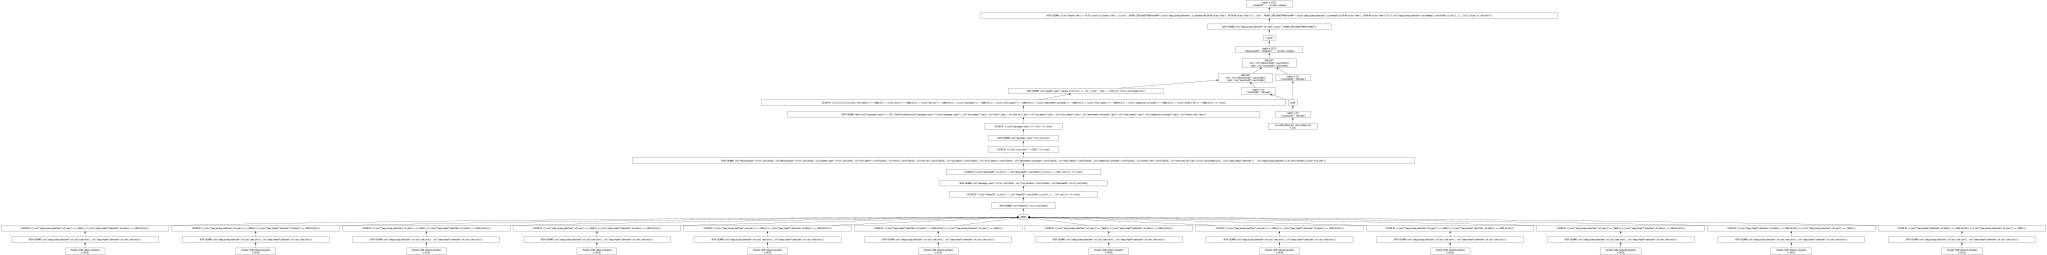

In [4]:
df_2024.show_graph()

In [5]:
df_2024 = df_2024.collect()

In [6]:
### 4. Feature extraction
### apply dummy encoding to features:
###     payment type
###     pickup borough
###     dropoff borough
df_2024 = df_2024.to_dummies(["payment_type", "pickup_borough", "dropoff_borough"])

In [7]:
df_2024

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type_card,payment_type_cash,payment_type_other,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,trip_time,pickup_borough_Bronx,pickup_borough_Brooklyn,pickup_borough_EWR,pickup_borough_Manhattan,pickup_borough_N/A,pickup_borough_Queens,pickup_borough_Staten Island,pickup_borough_Unknown,dropoff_borough_Bronx,dropoff_borough_Brooklyn,dropoff_borough_EWR,dropoff_borough_Manhattan,dropoff_borough_N/A,dropoff_borough_Queens,dropoff_borough_Staten Island,dropoff_borough_Unknown,is_airport_ride,is_rush_hour
i8,datetime[ms],datetime[ms],i8,f32,i8,cat,u8,u8,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,i64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,bool,bool
2,2024-01-01 00:57:55,2024-01-01 01:17:43,1,1.72,1,"""N""",0,1,0,17.700001,1.0,0.5,0.0,0.0,1.0,22.700001,2.5,0.0,19,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,false,false
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1,1.8,1,"""N""",1,0,0,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0,6,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,false,false
1,2024-01-01 00:17:06,2024-01-01 00:35:01,1,4.7,1,"""N""",1,0,0,23.299999,3.5,0.5,3.0,0.0,1.0,31.299999,2.5,0.0,17,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,false,false
1,2024-01-01 00:36:38,2024-01-01 00:44:56,1,1.4,1,"""N""",1,0,0,10.0,3.5,0.5,2.0,0.0,1.0,17.0,2.5,0.0,8,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,false,false
1,2024-01-01 00:46:51,2024-01-01 00:52:57,1,0.8,1,"""N""",1,0,0,7.9,3.5,0.5,3.2,0.0,1.0,16.1,2.5,0.0,6,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,false,false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2,2024-12-31 22:56:33,2024-12-31 23:05:57,1,1.9,1,"""N""",1,0,0,12.1,1.0,0.5,1.88,0.0,1.0,18.98,2.5,0.0,9,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,false,false
2,2024-12-31 23:18:37,2024-12-31 23:32:32,1,3.88,1,"""N""",0,1,0,19.1,1.0,0.5,0.0,0.0,1.0,24.1,2.5,0.0,13,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,false,false
2,2024-12-31 23:08:52,2024-12-31 23:34:59,1,5.53,1,"""N""",1,0,0,29.6,1.0,0.5,2.0,0.0,1.0,36.599998,2.5,0.0,26,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,false,false


In [8]:
df_2024 = df_2024.lazy()

In [9]:
df_2024 = (
    ### add time features:
    ###     quarter
    ###     month
    ###     day_of_month
    ###     day_of_week
    ###     is_weekend
    ### add column date, indicating day with given features
    df_2024.with_columns(
        date=pl.col("tpep_pickup_datetime").dt.date(),
        month=pl.col("tpep_pickup_datetime").dt.month(),
        quarter=pl.col("tpep_pickup_datetime").dt.quarter(),
        day_of_month=pl.col("tpep_pickup_datetime").dt.day(),
        day_of_week=pl.col("tpep_pickup_datetime").dt.weekday(),
        is_weekend=pl.col("tpep_pickup_datetime").dt.weekday().is_in([6,7])
    )

    ### add integer variables for counting daily events:
    ###      total number of rides (target variable)
    ###      number of airport rides
    ###      number of rush hour rides
    ### add features aggregating daily rides information:
    ###     average fare amount
    ###     median distance
    ###     sum of total amounts
    ###     total amount paid by card, cash, and other
    ###     total congestion surcharge
    ###     total number of passengers
    ### make sure to exclude other columns, unnecessary for machine learning, e.g. IDs, timestamps, unused financial information
    ### properly name all columns
    .group_by(
        "date",
        "quarter",
        "month",
        "day_of_month",
        "day_of_week",
        "is_weekend"
        
    )
    .agg([
        pl.len().alias("total_rides"),
        pl.sum("is_airport_ride").alias("airport_rides"),
        pl.sum("is_rush_hour").alias("rush_hour_rides"),
        pl.col("trip_distance").median().alias("median_trip_dist"),
        pl.mean("fare_amount").alias("avg_fare"),
        pl.sum("total_amount").alias("sum_total_amount"),
        pl.sum("payment_type_card").alias("total_card"),
        pl.sum("payment_type_cash").alias("total_cash"),
        pl.sum("payment_type_other").alias("total_other"),
        pl.sum("congestion_surcharge").alias("sum_congestion_surcharge"),
        pl.sum("passenger_count").alias("total_passengers")
    ])   
    .sort("date")
)

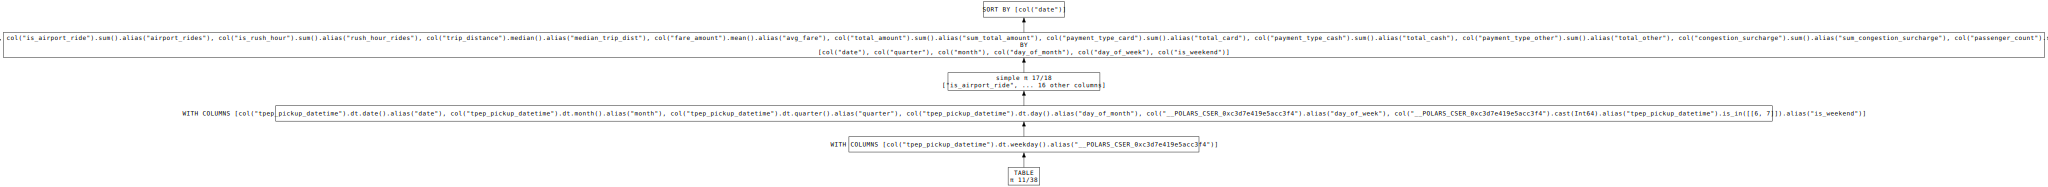

In [10]:
df_2024.show_graph()

In [11]:
df_2024 = df_2024.collect()

In [12]:
df_2024

date,quarter,month,day_of_month,day_of_week,is_weekend,total_rides,airport_rides,rush_hour_rides,median_trip_dist,avg_fare,sum_total_amount,total_card,total_cash,total_other,sum_congestion_surcharge,total_passengers
date,i8,i8,i8,i8,bool,u32,u32,u32,f32,f32,f32,i64,i64,i64,f32,i64
2024-01-01,1,1,1,1,false,69665,8352,19398,2.09,22.217703,2.185003e6,52970,14491,2204,156123.25,109137
2024-01-02,1,1,2,2,false,72585,9828,31015,1.82,21.506176,2.250542e6,55175,15388,2022,160617.5,104073
2024-01-03,1,1,3,3,false,79566,9140,33389,1.75,20.170843,2.332076e6,61343,16202,2021,177985.0,110973
2024-01-04,1,1,4,4,false,99077,8270,43572,1.75,18.866079,2.7605e6,78738,17994,2345,226627.5,135815
2024-01-05,1,1,5,5,false,98860,7460,40518,1.7,18.246851,2.6768e6,78701,17699,2460,227542.5,137166
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-12-27,4,12,27,5,false,80183,7276,30566,1.77,21.300371,2.453853e6,60370,15879,3934,181367.5,122599
2024-12-28,4,12,28,6,true,82229,6848,0,1.7,20.322123,2350799.5,60841,17306,4082,187202.5,128556
2024-12-29,4,12,29,7,true,74069,7751,0,1.92,22.271614,2.2985e6,55364,14601,4104,165090.0,115296


In [13]:
df_2024.write_parquet("data/dataset.parquet")

In [14]:
### 5. Data analysis
### print shape
df_2024.shape

(366, 17)

In [15]:
### show top rows
df_2024.head(10)

date,quarter,month,day_of_month,day_of_week,is_weekend,total_rides,airport_rides,rush_hour_rides,median_trip_dist,avg_fare,sum_total_amount,total_card,total_cash,total_other,sum_congestion_surcharge,total_passengers
date,i8,i8,i8,i8,bool,u32,u32,u32,f32,f32,f32,i64,i64,i64,f32,i64
2024-01-01,1,1,1,1,false,69665,8352,19398,2.09,22.217703,2.185003e6,52970,14491,2204,156123.25,109137
2024-01-02,1,1,2,2,false,72585,9828,31015,1.82,21.506176,2.250542e6,55175,15388,2022,160617.5,104073
2024-01-03,1,1,3,3,false,79566,9140,33389,1.75,20.170843,2.332076e6,61343,16202,2021,177985.0,110973
2024-01-04,1,1,4,4,false,99077,8270,43572,1.75,18.866079,2.7605e6,78738,17994,2345,226627.5,135815
2024-01-05,1,1,5,5,false,98860,7460,40518,1.7,18.246851,2.6768e6,78701,17699,2460,227542.5,137166
2024-01-06,1,1,6,6,true,90902,6795,0,1.66,17.773657,2.34757e6,72993,15607,2302,210287.5,133817
2024-01-07,1,1,7,7,true,64244,8411,0,1.8,20.211302,1871373.5,52055,10453,1736,144067.5,92525
2024-01-08,1,1,8,1,false,76969,7998,34807,1.71,19.189875,2.1845e6,62282,12786,1901,173725.0,100814
2024-01-09,1,1,9,2,false,85589,5923,38240,1.51,17.249916,2.2155e6,70606,13085,1898,197757.5,110095


In [16]:
### describe statistics
df_2024.describe()

statistic,date,quarter,month,day_of_month,day_of_week,is_weekend,total_rides,airport_rides,rush_hour_rides,median_trip_dist,avg_fare,sum_total_amount,total_card,total_cash,total_other,sum_congestion_surcharge,total_passengers
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""366""",366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2024-07-01 12:00:00""",2.505464,6.513661,15.756831,3.986339,0.284153,100100.04918,8979.101093,29943.382514,1.718675,19.953976,2.911505e6,82243.830601,14924.087432,2932.131148,230208.4375,134964.92623
"""std""",null,1.119551,3.455958,8.823592,2.006108,null,15371.426417,1715.760237,19695.067511,0.100871,1.20451,461545.0625,14160.573152,1357.339405,554.555287,37862.394531,18723.833939
"""min""","""2024-01-01""",1.0,1.0,1.0,1.0,0.0,47391.0,3355.0,0.0,1.5,16.676249,1.3260e6,34052.0,10244.0,1656.0,107825.0,74199.0
"""25%""","""2024-04-01""",2.0,4.0,8.0,2.0,null,89573.0,7869.0,0.0,1.66,19.125853,2581948.5,72543.0,14109.0,2566.0,203501.0,122222.0
"""50%""","""2024-07-02""",3.0,7.0,16.0,4.0,null,100782.0,9020.0,39519.0,1.7,19.952921,2.916712e6,83419.0,14966.0,2910.0,232825.0,134084.0
"""75%""","""2024-10-01""",4.0,10.0,23.0,6.0,null,110805.0,10144.0,44785.0,1.77,20.713577,3.2230e6,91739.0,15835.0,3271.0,256942.0,147190.0
"""max""","""2024-12-31""",4.0,12.0,31.0,7.0,1.0,141702.0,14904.0,56582.0,2.2,24.447693,4.464577e6,120997.0,17994.0,4596.0,330475.0,199442.0


In [17]:
### print schema
df_2024.schema

Schema([('date', Date),
        ('quarter', Int8),
        ('month', Int8),
        ('day_of_month', Int8),
        ('day_of_week', Int8),
        ('is_weekend', Boolean),
        ('total_rides', UInt32),
        ('airport_rides', UInt32),
        ('rush_hour_rides', UInt32),
        ('median_trip_dist', Float32),
        ('avg_fare', Float32),
        ('sum_total_amount', Float32),
        ('total_card', Int64),
        ('total_cash', Int64),
        ('total_other', Int64),
        ('sum_congestion_surcharge', Float32),
        ('total_passengers', Int64)])

<Axes: ylabel='Frequency'>

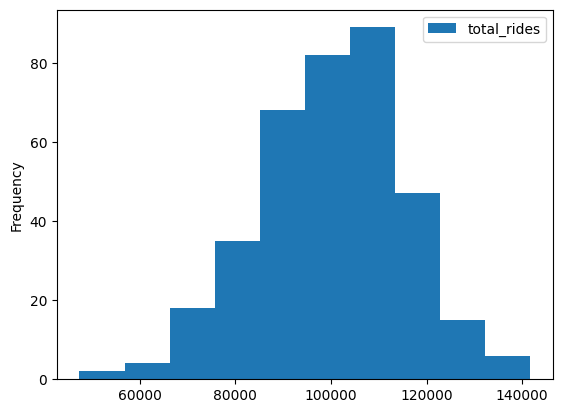

In [18]:
### plot target variable (daily number of rides):
###     histogram of values
df_2024.select("total_rides").to_pandas().plot.hist()

<Axes: xlabel='date'>

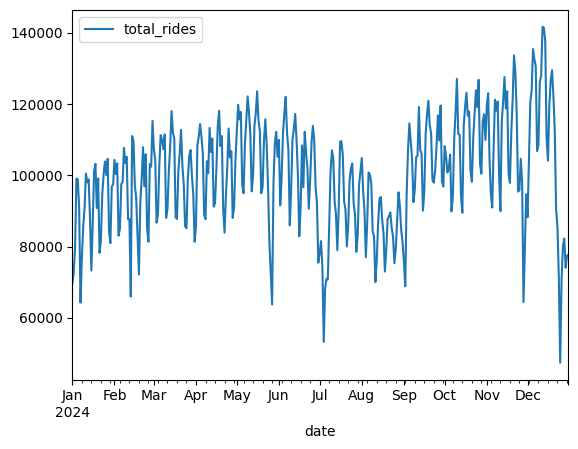

In [19]:
### line plot, date vs number of rides (remember to sort by date)
df_2024.select("date", "total_rides").to_pandas().plot.line(x="date",y="total_rides")